# Stats

> Statistics on lensing data

In [1]:
#| default_exp parameters

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
import numpy as np
from scipy.stats import poisson, norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import chi2

## Toy Model for Mass likelihood

In [4]:
#| export
# Define the power law function with index -2
def power_law(x, a=1, index=-2):
    return a * (x**index)

# Define the likelihood function for the Poisson process
def likelihood(observed_counts, expected_counts):
    poisson_pmf = poisson.pmf(observed_counts, expected_counts)
    return np.prod(poisson_pmf)

def generate_observed_counts_with_bump(bin_centers, a, index, bump_position, bump_height):
    power_law_counts = power_law(bin_centers, a=a, index=index)
    closest_bin = np.argmin(np.abs(bin_centers - bump_position))
    power_law_counts[closest_bin] += bump_height
    return np.random.poisson(power_law_counts)

In [5]:
# Generate an example set of binned observations
np.random.seed(42)

min_bin = 1
max_bin = 10
bin_edges = np.linspace(min_bin,max_bin,10)  # Assuming bins from -6 to -2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

a = 50  # Scale factor to match the example observed_counts
bump_position = 5  # Bump location
bump_height = 20  # Bump height

index = -2

observed_counts = generate_observed_counts_with_bump(bin_centers, a, index, bump_position, bump_height)

# Calculate the expected counts based on the power law model
expected_counts = power_law(bin_centers, a=a)

# Calculate the total likelihood
total_likelihood = likelihood(observed_counts, expected_counts)

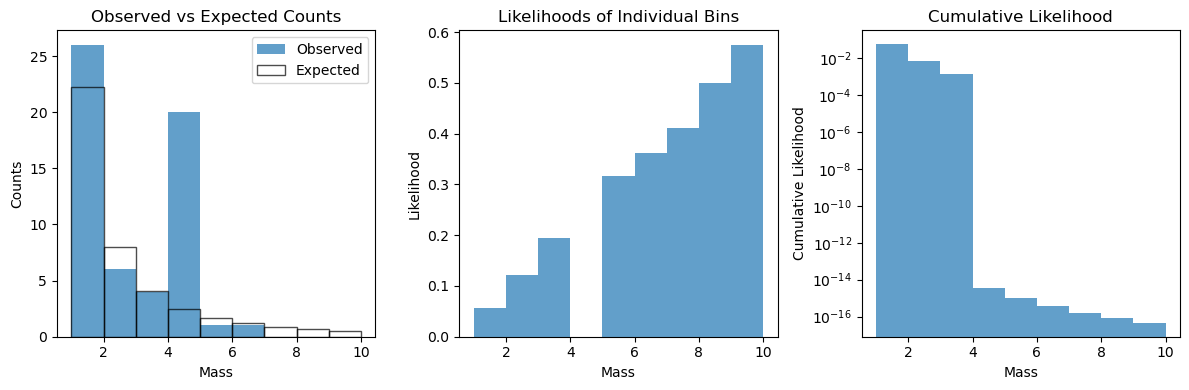

In [6]:
# Plot the observed and expected counts
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.bar(bin_centers, observed_counts, width=1, alpha=0.7, label="Observed")
plt.bar(bin_centers, expected_counts, width=1, alpha=0.7, label="Expected", edgecolor='black', linewidth=1, fill=False)
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.legend()
plt.title("Observed vs Expected Counts")

# Plot the likelihoods of individual bins
likelihoods = poisson.pmf(observed_counts, expected_counts)
plt.subplot(132)
plt.bar(bin_centers, likelihoods, width=1, alpha=0.7)
plt.xlabel("Mass")
plt.ylabel("Likelihood")
plt.title("Likelihoods of Individual Bins")

# Plot the cumulative likelihood
cumulative_likelihood = np.cumprod(likelihoods)
plt.subplot(133)
plt.bar(bin_centers, cumulative_likelihood, width=1, alpha=0.7)
plt.xlabel("Mass")
plt.ylabel("Cumulative Likelihood")
plt.yscale("log")
plt.title("Cumulative Likelihood")

plt.tight_layout()
plt.show()

## MLE and Log Likelihood Ratio Test

In [11]:
from scipy.optimize import differential_evolution

# Define the negative log-likelihood function for optimization with continuous bump_position
def neg_log_likelihood(params, bin_centers, observed_counts):
    a, index, bump_position, bump_height = params
    expected_counts = power_law(bin_centers, a=a, index=index)
    closest_bin = np.argmin(np.abs(bin_centers - bump_position))
    expected_counts[closest_bin] += bump_height
    return -np.sum(poisson.logpmf(observed_counts, expected_counts))

# Generate example observed counts with a bump
a = 200
index = -2
bump_position = 6
bump_height = 20

observed_counts = generate_observed_counts_with_bump(bin_centers, a, index, bump_position, bump_height)

# Set bounds for the parameters
bounds = [(1, 300), (-4, -1), (min_bin, max_bin), (0, 200)]

# Use differential evolution to optimize the parameters
result_bump = differential_evolution(neg_log_likelihood, bounds=bounds, args=(bin_centers, observed_counts), strategy='best1bin', popsize=10, tol=1e-4)

optimized_params_bump = result_bump.x
expected_counts_opt = generate_observed_counts_with_bump(bin_centers, *optimized_params_bump)

print("Optimized parameters: a = {:.2f}, index = {:.2f}, bump_position = {:.2f}, bump_height = {:.2f}".format(*optimized_params_bump))
print("True parameters: a = {:.2f}, index = {:.2f}, bump_position = {:.2e}, bump_height = {:.2f}".format(a, index, bump_position, bump_height))


Optimized parameters: a = 230.29, index = -2.16, bump_position = 5.22, bump_height = 29.26
True parameters: a = 200.00, index = -2.00, bump_position = 6.00e+00, bump_height = 20.00


In [12]:
log_likelihood_bump_opt = -result_bump.fun
log_likelihood_no_bump_opt = -neg_log_likelihood([optimized_params_bump[0], optimized_params_bump[1], optimized_params_bump[2], 0], bin_centers, observed_counts)

# Calculate the likelihood ratio test statistic
lr_statistic = -2 * (log_likelihood_no_bump_opt - log_likelihood_bump_opt)

# Calculate the p-value using a chi-square distribution
p_value = chi2.sf(lr_statistic, df=2)  # Two degrees of freedom for the difference in number of parameters

# Print the results
print("Log-likelihood with bump:", log_likelihood_bump_opt)
print("Log-likelihood without bump:", log_likelihood_no_bump_opt)
print("Likelihood ratio test statistic:", lr_statistic)
print("p-value:", p_value)
if p_value < 0.05:
    print("The null hypothesis is rejected at the 5% significance level.")
else:
    print("The null hypothesis is not rejected at the 5% significance level.")

Log-likelihood with bump: -21.307995372924495
Log-likelihood without bump: -55.096216192725684
Likelihood ratio test statistic: 67.57644163960238
p-value: 2.1181764959097517e-15
The null hypothesis is rejected at the 5% significance level.


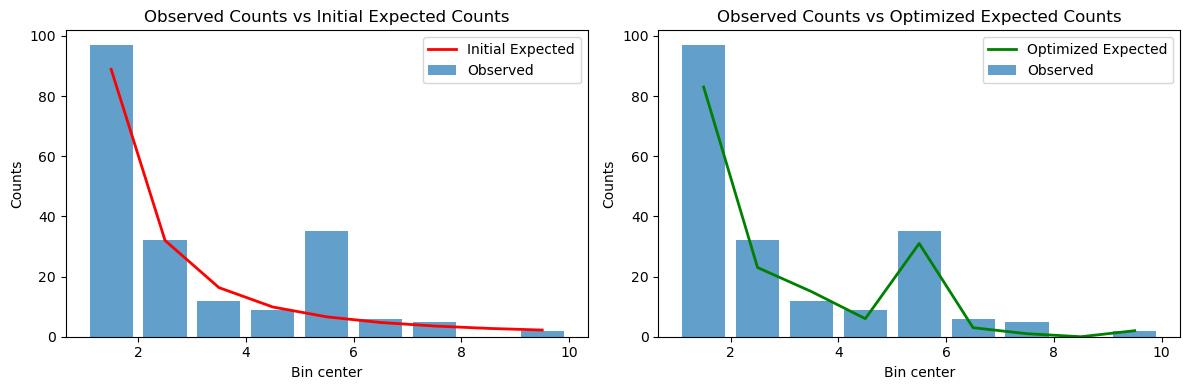

In [13]:
# Plot the observed counts and the initial/optimized expected counts
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.bar(bin_centers, observed_counts, alpha=0.7, label="Observed")
plt.plot(bin_centers, power_law(bin_centers, a=a, index=index), label="Initial Expected", color='r', linewidth=2)
plt.xlabel("Bin center")
plt.ylabel("Counts")
plt.legend()
plt.title("Observed Counts vs Initial Expected Counts")

plt.subplot(122)
plt.bar(bin_centers, observed_counts, alpha=0.7, label="Observed")
plt.plot(bin_centers, expected_counts_opt, label="Optimized Expected", color='g', linewidth=2)
plt.xlabel("Bin center")
plt.ylabel("Counts")
plt.legend()
plt.title("Observed Counts vs Optimized Expected Counts")

plt.tight_layout()
plt.show()


In [14]:
#| hide
import nbdev; nbdev.nbdev_export()